In [14]:
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

from scipy import special

from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Introduction

At first glance the perceptron bears many similarities with ordinary Linear Regression in that it can learn linearly separable patterns. Two things that differentiate the perceptron from Linear Regression though, are the "activation function" and how the weights are set. 
- Whereas the parameters of Linear Regressors tend to be set using ordinary least squares (OLS) perceptrons are "trained" using gradient descent. We've learned that initializing weights randomly is important for training. However, this has the consequence that a perceptron can potentially have different scores after training depending on what weights it started with - though this is really only a concern for low dimensional problems.
- A perceptron is usually paired with an "activation function" which can introduce nonlinearity into the model. Essentially the activation function takes the output of a perceptron and maps it to something like a sigmoid function, a hyperbolic tangent function, or some other differentiable function.

In [2]:
# Let us implement a perceptron from scratch
# to see what the algorithm is like

class OurPerceptron:
  
    # just like linear regression we have a weight and a bias
    def __init__ (self):
        self.w = None    # weight (aka coefficient)
        self.b = None    # bias (aka intercept)
     
    # return a binary classifier model with a Heaviside step activation function
    # https://en.wikipedia.org/wiki/Heaviside_step_function
    def model(self, x):
        # this is for binary classification
        # for regression you might use something like tanh, or sigmoid
        return 1 if (np.dot(self.w, x) >= self.b) else 0
  
    # predict using the linear model
    def predict(self, X):
        ŷ = []
        for x in X:
            result = self.model(x)
            ŷ.append(result)
        return np.array(ŷ)
    
    def fit(self, X, Y, epochs = 1, lr = 1):
        self.w = np.ones(X.shape[1])
        self.b = 0
        accuracy = {}
        max_accuracy = 0
        wt_matrix = []
        
        # run through dataset as many times as we specify "epochs"
        for i in range(epochs):
            for x, y in zip(X, Y):
                ŷ = self.model(x)
                # adjust weights
                if y == 1 and ŷ == 0:
                    self.w = self.w + lr * x
                    self.b = self.b - lr * 1
                elif y == 0 and ŷ == 1:
                    self.w = self.w - lr * x
                    self.b = self.b + lr * 1
  
            wt_matrix.append(self.w)    
            accuracy[i] = accuracy_score(self.predict(X), Y)
            if (accuracy[i] > max_accuracy):
                max_accuracy = accuracy[i]
                chkptw = self.w
                chkptb = self.b
        #checkpoint (Save the weights and b value)
        self.w = chkptw
        self.b = chkptb

        #return the weight matrix, that contains weights over all epochs
        return np.array(wt_matrix)

In [3]:
# let's load a small dataset to try it out with
#load the breast cancer data
breast_cancer = datasets.load_breast_cancer()

print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [4]:
#convert the data to pandas dataframe.

data = pd.DataFrame(breast_cancer.data, columns = breast_cancer.feature_names)
data["class"] = breast_cancer.target
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
# notice that the magnitudes of the values are very different
# the mean radius is 14
# the mean smoothness is 0.09
# the mean worst area is 880

data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [58]:
# to help the Perceptron learn more efficiently, we will scale these values
# using a minmaxscalerwhich normalizes values between 0 and 1

# different ML models are sensitive to different degrees of scaling
# even though a model is supposed to be "scale invariant" it always helps convergence
# if you scale your values

# be aware that when applying scaling during creation of the model
# that it might lead to complexity when deploying it in production
# you might need to store the scaling parameters and validate that they're being
# applied to new data in the same way as when you designed the model

from sklearn.preprocessing import MinMaxScaler

#perform scaling on the data.
X = data.drop("class", axis = 1)
Y = data["class"]
mnscaler = MinMaxScaler()
X = mnscaler.fit_transform(X)
X = pd.DataFrame(X, columns=data.drop("class",axis = 1).columns)

#train test split.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, stratify = Y, random_state = 1)

In [59]:
# now all the values are normalized 

X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.338222,0.323965,0.332935,0.216920,0.394785,0.260601,0.208058,0.243137,0.379605,0.270379,...,0.296663,0.363998,0.283138,0.170906,0.404138,0.220212,0.217403,0.393836,0.263307,0.189596
std,0.166787,0.145453,0.167915,0.149274,0.126967,0.161992,0.186785,0.192857,0.138456,0.148702,...,0.171940,0.163813,0.167352,0.139932,0.150779,0.152649,0.166633,0.225884,0.121954,0.118466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223342,0.218465,0.216847,0.117413,0.304595,0.139685,0.069260,0.100944,0.282323,0.163016,...,0.180719,0.241471,0.167837,0.081130,0.300007,0.116337,0.091454,0.223127,0.185098,0.107700
50%,0.302381,0.308759,0.293345,0.172895,0.390358,0.224679,0.144189,0.166501,0.369697,0.243892,...,0.250445,0.356876,0.235320,0.123206,0.397081,0.179110,0.181070,0.343402,0.247782,0.163977
75%,0.416442,0.408860,0.416765,0.271135,0.475490,0.340531,0.306232,0.367793,0.453030,0.340354,...,0.386339,0.471748,0.373475,0.220901,0.494156,0.302520,0.305831,0.554639,0.318155,0.242949
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
# let us set up a baseline

m = OurPerceptron()

wt_matrix = m.fit(np.array(X_train), np.array(Y_train), 300, 0.3)

print(accuracy_score(m.predict(np.array(X_test)), np.array(Y_test)))

# we score quite well

0.9649122807017544


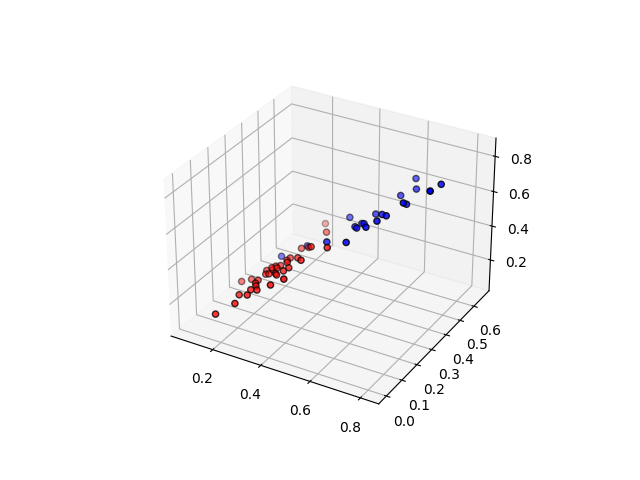

In [67]:
# let us investigate the dataset

# when we have high dimensional datasets it's not always easy to plot them
# in such a way that it becomes clear how to linearly separate classes
# try visualizing different columns to see how the two classes are separable

# how many dimensions do you think we need in order to score well on this dataset?

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], X_test.iloc[:, 2], c=Y_test, cmap='bwr', s=20, edgecolors="k")

In [63]:
# based on the image above it seems like the first two variables should suffice

m = OurPerceptron()

wt_matrix = m.fit(np.array(X_train.iloc[:,0:2]), np.array(Y_train), 300, 0.3)

print(accuracy_score(m.predict(np.array(X_test.iloc[:,0:2])), np.array(Y_test)))

# look at that! the model scores well despite only including 3 columns of data

0.9473684210526315


# Multiclass Perceptron

In [69]:
# let us grab a dataset that is slightly more complex just to see the difference in activation functions

X, Y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

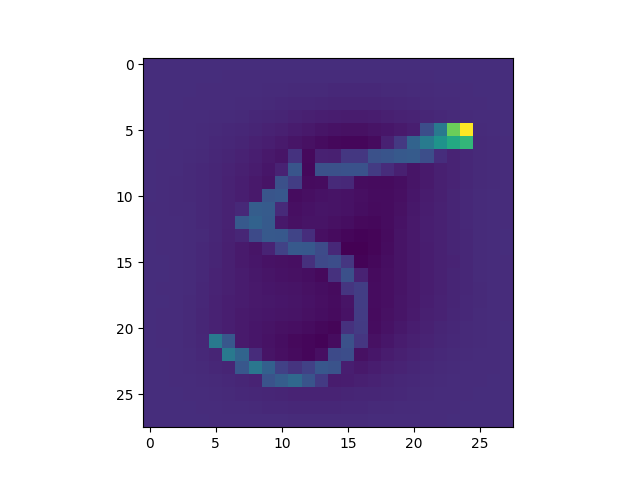

In [70]:
# MNIST is a dataset of handwritten digits
# it will be (slightly) more difficult for our perceptron to classify correctly

# clear old visualizations
plt.close('all')

# visualize the points
fig, ax = plt.subplots()
plt.imshow(X_train[0].reshape((28,28)))

In [71]:
# let's start off by using the Perceptron provided by Scikit Learn

m = Perceptron(max_iter=300, eta0=0.3, n_jobs=-1)

m.fit(X_train, Y_train)

accuracy_score(m.predict(X_test), Y_test)

# there is a fairly hard limit on what score we can achieve with a single layer perceptron

0.8802857142857143

# Multilayer Perceptrons (aka Deep Neural Networks)

Multilayer Perceptrons are built in the following way:
- build a perceptron layer with as many inputs as the dimensionality of the input and an arbitrary number of outputs
- add another perceptron in front with inputs to match the outputs of the previous layer and outputs to match the problem

Normally, this is referred to as a fully connected feed-forward neural network.

ADVANTAGE:

Ordinary Perceptrons are only capable of learning linearly separable patterns. However, when connecting them in sequence (rather than in parallel) each layer adds a nonlinear capability. Because perceptrons in the deeper layers can control the entire parameter space, they are very computationally efficient given their potential expressivity.

DISADVANTAGE:

Given that Multilayer Perceptrons (MLP) learn so well, its is easier to overprovision the network and let it score well immediately. However, one must be careful that the network does not simply overfit the data (i.e. set specialized parameters so the dataset is effectively memorized). One way of overcoming this is by regularizing the data using L2, network dropout, or any other number of available techniques.

In [31]:
# let's see what we can achieve by combining two layers of perceptrons
# for now we will not add an activation function

m = MLPClassifier(hidden_layer_sizes=(128), max_iter = 15, 
                  activation = 'identity', solver = 'sgd', verbose=1)

m.fit(X_train, Y_train)

accuracy_score(m.predict(X_test), Y_test)

Iteration 1, loss = 0.72082074
Iteration 2, loss = 0.38668823
Iteration 3, loss = 0.34384436
Iteration 4, loss = 0.32270696
Iteration 5, loss = 0.30958942
Iteration 6, loss = 0.30036779
Iteration 7, loss = 0.29345113
Iteration 8, loss = 0.28790683
Iteration 9, loss = 0.28338840
Iteration 10, loss = 0.27949964
Iteration 11, loss = 0.27617664
Iteration 12, loss = 0.27327693
Iteration 13, loss = 0.27060728
Iteration 14, loss = 0.26816552
Iteration 15, loss = 0.26630500


/home/r3tex/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9154285714285715

In [23]:
m.coefs_[0].shape

(784, 32)

In [22]:
m.coefs_[1].shape

(32, 10)

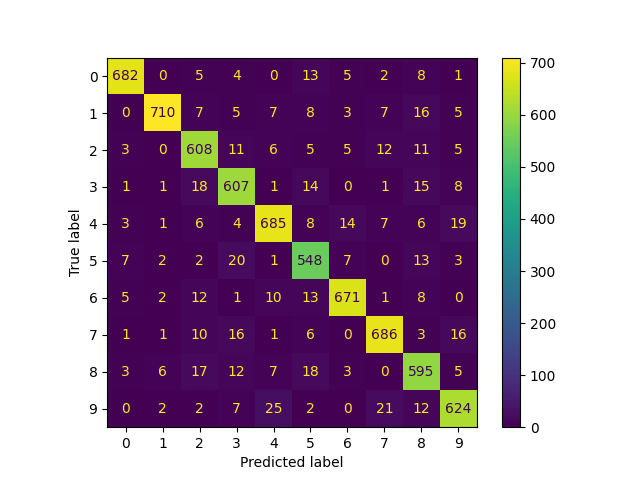

In [29]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(m.predict(X_test), Y_test)).plot()

In [34]:
# let us add a logistic sigmoid function as the activation function
# and see exactly what difference it makes

m = MLPClassifier(hidden_layer_sizes=(128), max_iter = 15, 
                  activation = 'tanh', solver = 'sgd', verbose=1)

m.fit(X_train, Y_train)

accuracy_score(m.predict(X_test), Y_test)

Iteration 1, loss = 0.87267918
Iteration 2, loss = 0.44257172
Iteration 3, loss = 0.37445820
Iteration 4, loss = 0.33936413
Iteration 5, loss = 0.31641501
Iteration 6, loss = 0.29949986
Iteration 7, loss = 0.28613004
Iteration 8, loss = 0.27513594
Iteration 9, loss = 0.26570017
Iteration 10, loss = 0.25743872
Iteration 11, loss = 0.25007075
Iteration 12, loss = 0.24344129
Iteration 13, loss = 0.23737181
Iteration 14, loss = 0.23173208
Iteration 15, loss = 0.22653519


/home/r3tex/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9305714285714286

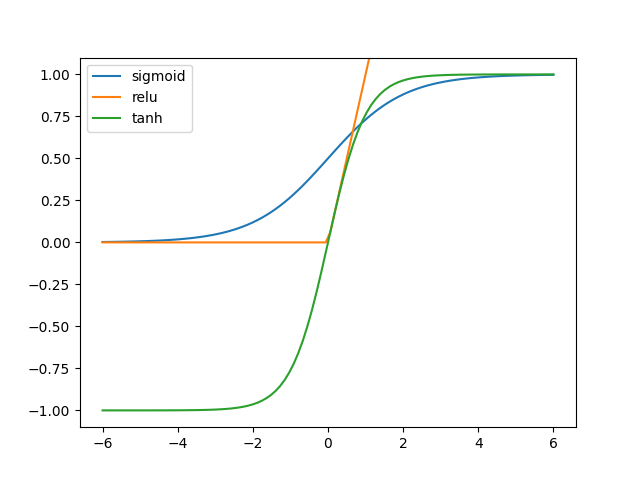

In [54]:
x = np.linspace(-6, 6, 100)
relu = np.maximum(0, x)
tanh = np.tanh(x)
σ = special.expit(x)

# clear old visualizations
plt.close('all')

# visualize the points
fig, ax = plt.subplots()
plt.plot(x, σ, label='sigmoid')
plt.plot(x, relu, label='relu')
plt.plot(x, tanh, label='tanh')
ax.set_ylim(-1.1, 1.1)
ax.legend()
plt.show()

In [55]:
# let us switch to the ADAM optimizer and see what effect it has

m = MLPClassifier(hidden_layer_sizes=(128), max_iter = 15, 
                  activation = 'tanh', solver = 'adam', verbose=1)

m.fit(X_train, Y_train)

accuracy_score(m.predict(X_test), Y_test)

Iteration 1, loss = 0.33908873
Iteration 2, loss = 0.17435186
Iteration 3, loss = 0.12462732
Iteration 4, loss = 0.09398596
Iteration 5, loss = 0.07234046
Iteration 6, loss = 0.05663119
Iteration 7, loss = 0.04449796
Iteration 8, loss = 0.03482054
Iteration 9, loss = 0.02710012
Iteration 10, loss = 0.02094703
Iteration 11, loss = 0.01680984
Iteration 12, loss = 0.01329923
Iteration 13, loss = 0.01047427
Iteration 14, loss = 0.00834886
Iteration 15, loss = 0.00668058


/home/r3tex/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9667142857142857

In [ ]:
# finally let us switch to rectifier and get a final score

m = MLPClassifier(hidden_layer_sizes=(128), max_iter = 15, 
                  activation = 'relu', solver = 'adam', verbose=1)

m.fit(X_train, Y_train)

accuracy_score(m.predict(X_test), Y_test)

Iteration 1, loss = 0.55955999
Iteration 2, loss = 0.20189104
Iteration 3, loss = 0.15362927
Iteration 4, loss = 0.12711400
Iteration 5, loss = 0.10939570
Iteration 6, loss = 0.09508237
Iteration 7, loss = 0.08450988


In [ ]:
from sklearn.model_selection import GridSearchCV

param = {'hidden_layer_sizes':[(128),(64),(32),(16),(32,16)],
         'activation':['relu','tanh',]}

m = svm.SVC()
msvm = GridSearchCV(estimator=m, param_grid=param, scoring='accuracy', refit=True, verbose=1, cv=5)